In [12]:
import json
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
# Function to join two dataframes on the track URI (song ID)
def join(playlist_df, song_df, class_col = None):
    # Cleans the track URI by extracting the last part after ':'
    clean_uri = lambda x : x.split(':')[-1]
    playlist_df.track_uri = playlist_df.track_uri.apply(clean_uri)

    # Merges the playlist and song dataframes on the cleaned track URI
    merge_df = pd.merge(playlist_df, song_df, how='inner', left_on='track_uri', right_on="id")
    
    # If a class column is provided, add it to the merged dataframe
    if class_col is not None:
        merge_df['label'] = class_col
    return merge_df


# Function to filter playlists based on a song threshold
def filter_playlists(playlists, songs, threshold):
    pl_lst = []
    # Cleans the track URI by extracting the last part after ':'
    clean_uri = lambda x : x.split(':')[-1]
    for pl in playlists:
        # Extracts tracks from the current playlist and cleans the track URIs
        current_tracks = pd.DataFrame(pl['tracks'])
        current_tracks.track_uri = current_tracks.track_uri.apply(clean_uri)
        df = pd.DataFrame(current_tracks).drop('pos', axis=1).drop_duplicates(ignore_index=True)
        # Adds the playlist name as a column
        df['playlist'] = pl['name']

        pl_lst.append(df)
        
    # Joins all playlists into one dataframe, filters based on the threshold, and resets index
    return join(
        pd.concat(pl_lst), songs).groupby(by='playlist').filter(lambda x : len(x) > threshold
    ).sort_values('playlist').reset_index(drop=True)

def load_playlist_data(playlist_file):
    with open(playlist_file, 'r') as file:
        playlists = json.load(file)
    return playlists

def load_playlist_data(playlist_file):
    with open(playlist_file, 'r') as file:
        playlists = json.load(file)
    return playlists

def load_track_features(file_path):
    """
    Load the track features from the provided CSV file.
    """
    return pd.read_csv(file_path)

def extract_playlist_data(playlist_name, playlist_data):
    """
    Extract the data for a specific playlist.
    """
    return playlist_data[playlist_data['playlist'] == playlist_name]

def calculate_feature_distributions(playlist_data):
    """
    Calculate the distributions for each feature in the playlist.
    """
    # Calculate distributions for each feature
    feature_columns = ['danceability', 'energy', 'acousticness', 'valence', 'tempo']
    distributions = {feature: playlist_data[feature].describe() for feature in feature_columns}
    return distributions

def score_song(song, feature_distributions):
    """
    Score a song based on its features' alignment with the playlist feature distributions.
    """
    score = 0
    for feature in feature_distributions:
        # Example scoring logic, this can be refined
        if feature_distributions[feature]['25%'] <= song[feature] <= feature_distributions[feature]['75%']:
            score += 1
    return score

def recommend_songs(playlist_name, playlist_data, track_features_data, threshold=3, max_tracks=10):
    """
    Recommend songs for the given playlist.
    Parameters:
    - playlist_name: Name of the playlist for which recommendations are made.
    - playlist_data: DataFrame containing playlist data.
    - track_features_data: DataFrame containing features of tracks.
    - threshold: Score threshold for a track to be recommended.
    - max_tracks: Maximum number of tracks to recommend.
    """
    # Extract playlist data
    specific_playlist_data = extract_playlist_data(playlist_name, playlist_data)
    
    # Calculate feature distributions
    feature_distributions = calculate_feature_distributions(specific_playlist_data)

    # Score and select songs
    recommendations = []
    for _, song in track_features_data.iterrows():
        if len(recommendations) >= max_tracks:
            break
        song_score = score_song(song, feature_distributions)
        if song_score >= threshold:
            recommendations.append(song['name'])

    return recommendations

def plot_feature_distribution_with_recommendations(playlist_songs, recommended_songs, features, song_data):
    # Determine the number of plots needed
    num_features = len(features)
    num_columns = 3  # Adjust the number of columns as needed
    num_rows = (num_features + num_columns - 1) // num_columns
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 4))
    axes = axes.flatten()
    
    # Plot histogram and KDE for each feature
    for i, feature in enumerate(features):
        ax = axes[i]
        # Histogram and KDE for the playlist's feature distribution
        sns.histplot(playlist_songs[feature], kde=True, ax=ax, stat="density", bins=30, label=f"Original Playlist {feature} PDF")
        
        # Overlay recommended songs' feature values as points on the KDE plot
        if recommended_songs:
            recommended_features = song_data[song_data['name'].isin(recommended_songs)][feature]
            sns.rugplot(recommended_features, ax=ax, color='blue', height=-0.02, label='Recommended Songs')

        ax.set_title(f"'{feature}' Distribution with Recommended Songs")
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.legend()

    # Remove empty subplots
    for i in range(num_features, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()



In [8]:
# Load data
playlist_file = 'mpd.slice.0-999.json'
song_file = 'tracks_features.csv' 
songs = pd.read_csv(song_file)
playlists = load_playlist_data(playlist_file)['playlists']

# Filter playlists
filtered_playlist_data = filter_playlists(playlists, songs, 30)

# (Getting a feel for the data)
# Save to CSV
filtered_playlist_data.to_csv('filtered_playlists.csv', index=False)

# Extracting unique playlist names from the 'playlist' column
playlist_names = filtered_playlist_data['playlist'].unique().tolist()

# Outputting the playlist names
#print("Filtered Playlist Names:")
#for name in playlist_names:
 #   print(name)

print(len(filtered_playlist_data))

2322


In [9]:
# Usage
track_features_data = load_track_features('tracks_features.csv')
recommended_songs = recommend_songs('2015', filtered_playlist_data, track_features_data, max_tracks=10)


In [10]:
print(recommended_songs)

['Testify', 'Guerrilla Radio', 'Calm Like a Bomb', 'Mic Check', 'Sleep Now In the Fire', 'Maria', 'Voice of the Voiceless', 'New Millennium Homes', 'Ashes In the Fall', 'Bombtrack']


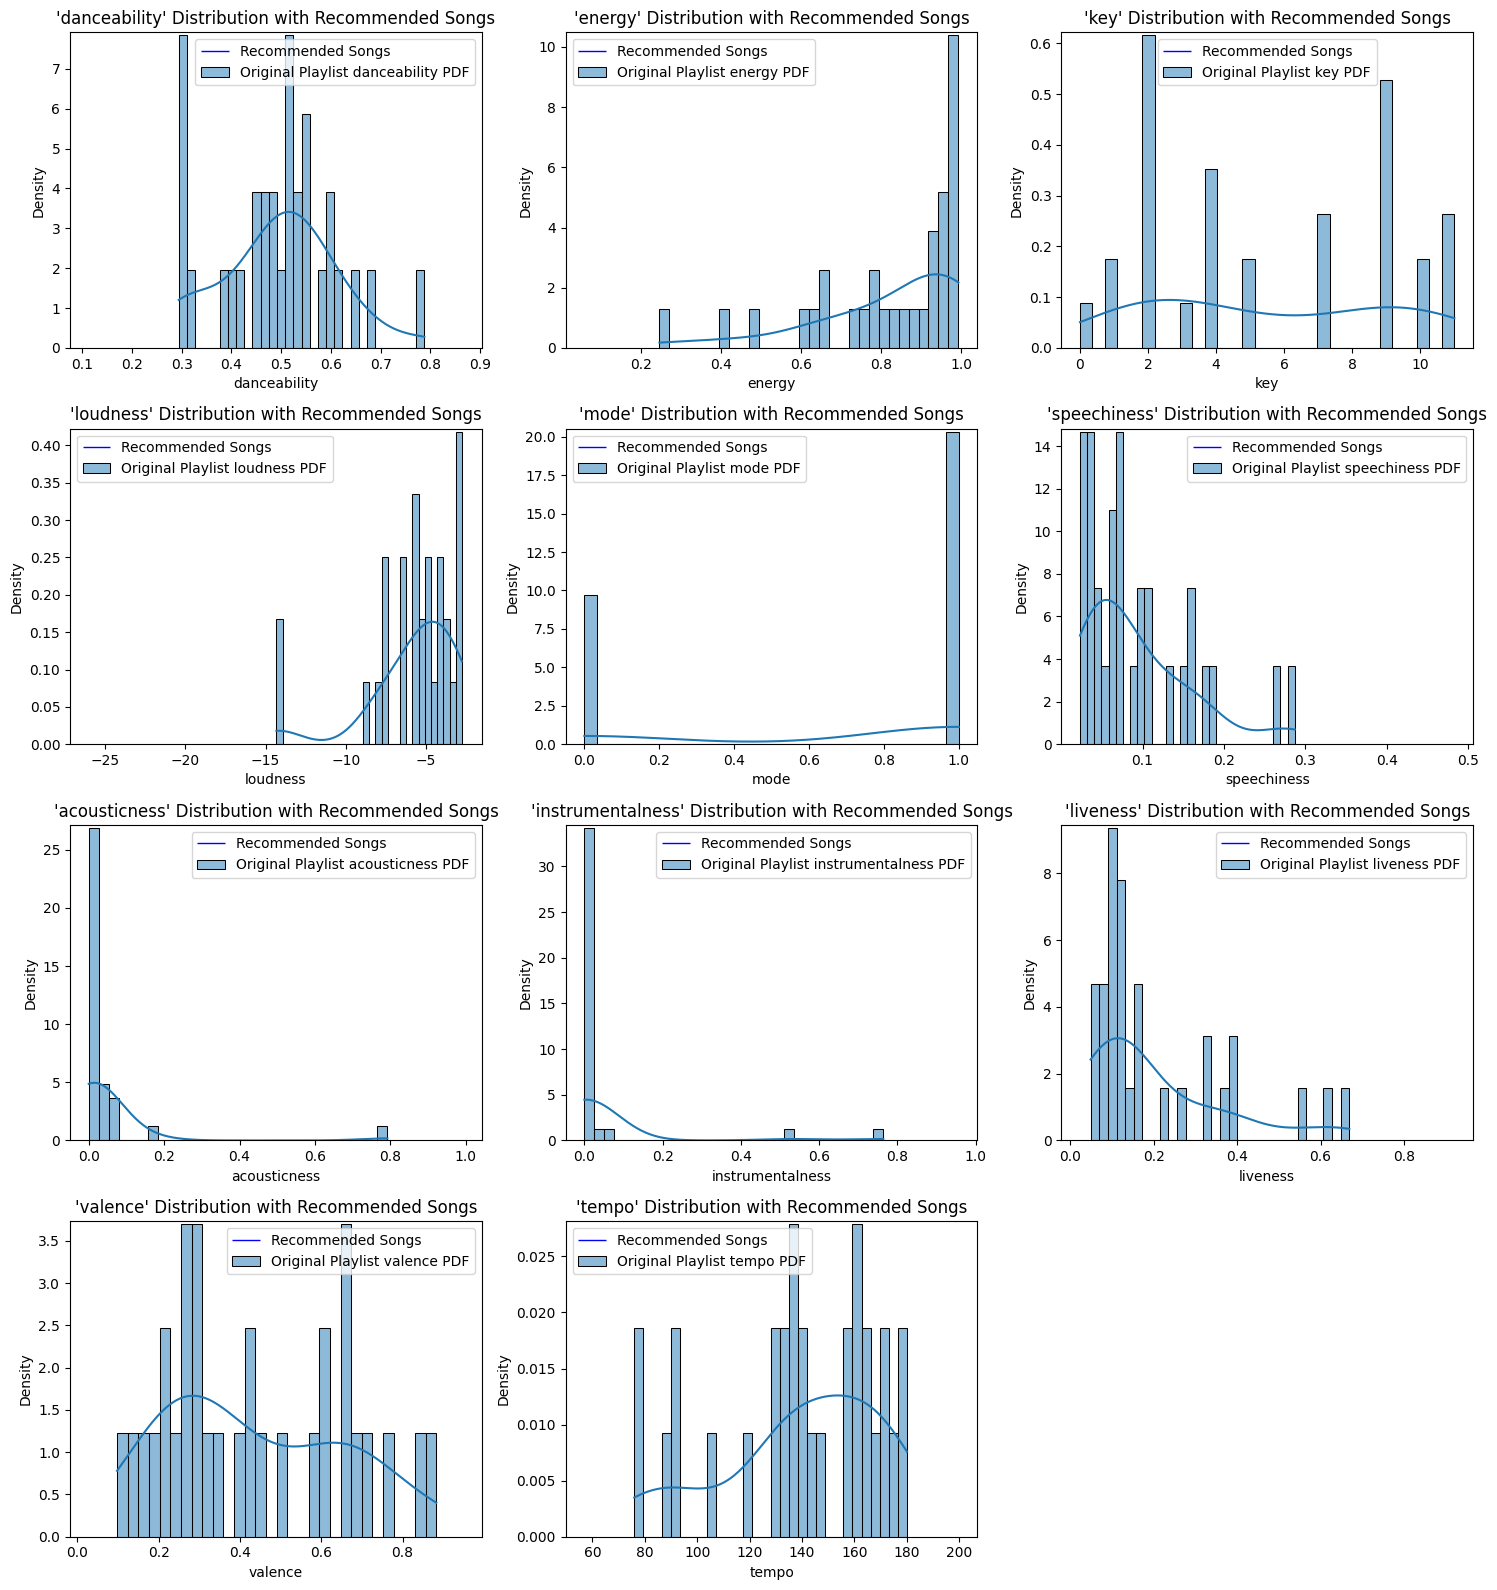

In [13]:
# List of features to plot
features_to_plot = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                    'instrumentalness', 'liveness', 'valence', 'tempo']


# Filter out the '2015' playlist from filtered_playlist_data
selected_playlist = filtered_playlist_data[filtered_playlist_data['playlist'] == '2015']
song_data = pd.read_csv('tracks_features.csv')


plot_feature_distribution_with_recommendations(selected_playlist, recommended_songs, features_to_plot, song_data)